In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Load CSV data
df = pd.read_csv('2010_Chronic_Conditions.csv')
df.head()

,BENE_SEX_IDENT_CD,BENE_AGE_CAT_CD,CC_ALZHDMTA,CC_CANCER,CC_CHF,CC_CHRNKIDN,CC_COPD,CC_DEPRESSN,CC_DIABETES,CC_ISCHMCHT,...,BENE_COUNT_PC_LT_12,AVE_MO_EN_PC_LT_12,BENE_COUNT_PC_EQ_12,BENE_COUNT_PD_LT_12,AVE_MO_EN_PD_LT_12,AVE_PDE_CST_PD_LT_12,AVE_PDE_PD_LT_12,BENE_COUNT_PD_EQ_12,AVE_PDE_CST_PD_EQ_12,AVE_PDE_PD_EQ_12
0,1,1,NaN,NaN,0,0,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,7230.0,49.877
1,1,1,NaN,NaN,0,0,NaN,NaN,0,0,...,NaN,NaN,NaN,42.0,5.952,2165.0,24.81,203.0,7163.0,73.404
2,1,1,NaN,NaN,0,0,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,4007.0,51.481
3,1,1,NaN,NaN,0,0,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209.0,9021.0,75.732
4,1,1,NaN,NaN,0,0,NaN,NaN,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,5925.0,61.591


In [4]:
# Total Medicare Cost is calculated as the sum of Part A, Part B and Part D
df['Total_Cost'] = (
    df['AVE_PA_PAY_PA_EQ_12'].fillna(0) +  # Part A 
    df['AVE_CA_PAY_PB_EQ_12'].fillna(0) +  # Part B 
    df['AVE_OP_PAY_PB_EQ_12'].fillna(0) +  # Part B 
    df['AVE_PDE_CST_PD_EQ_12'].fillna(0)   # Part D 
)

In [5]:
# Chronic condition columns (binary flags)
condition_cols = [col for col in df.columns if col.startswith('CC_')]

# Demographic columns
demographic_cols = ['BENE_SEX_IDENT_CD', 'BENE_AGE_CAT_CD']

# Utilization metrics (volume of services used)
utilization_cols = [
    'AVE_IP_ADM_PA_EQ_12',     # Inpatient admits
    'AVE_SNF_DAYS_PA_EQ_12',   # Skilled nursing facility days
    'AVE_CA_VST_PB_EQ_12',     # Physician visits
    'AVE_OP_VST_PB_EQ_12',     # Outpatient visits
    'AVE_PDE_PD_EQ_12'         # Prescription fills
]

In [6]:
# Combine all feature columns
feature_cols = demographic_cols + condition_cols + utilization_cols

# Create feature matrix
X = df[feature_cols].copy()

# Fill missing values in binary flags and utilization columns with 0
X = X.fillna(0)


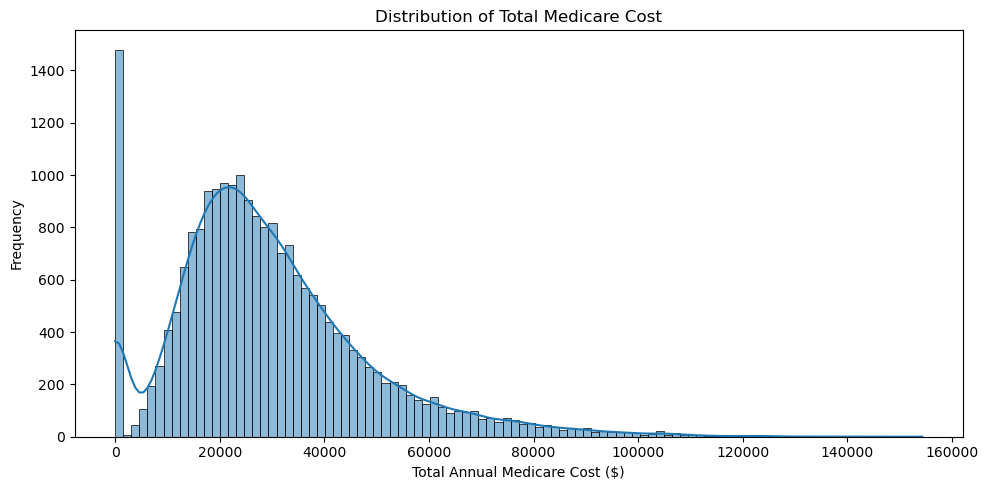

In [9]:
#Look at the distribution of the data
plt.figure(figsize=(10, 5))
sns.histplot(df['Total_Cost'], bins=100, kde=True)
plt.title("Distribution of Total Medicare Cost")
plt.xlabel("Total Annual Medicare Cost ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [10]:
# Apply log(1 + x) transformation to stabilize variance and reduce skew
y = df['Total_Cost']
y_log = np.log1p(y)

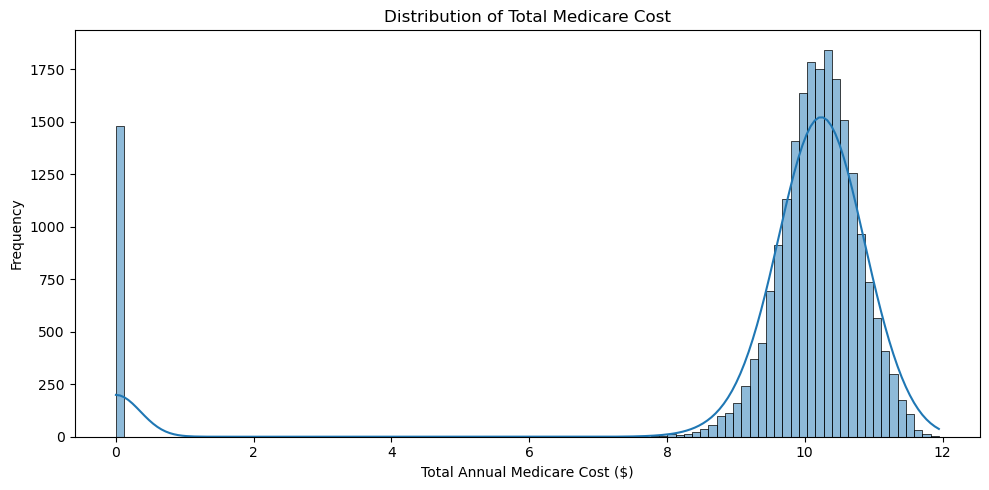

In [12]:
#Distribution of the data after log transformation
plt.figure(figsize=(10, 5))
sns.histplot(y_log, bins=100, kde=True)
plt.title("Distribution of Total Medicare Cost")
plt.xlabel("Total Annual Medicare Cost ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [14]:
# Linear Regression 
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [15]:
# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [16]:
def evaluate_model(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }

In [18]:
# Evaluate both models
lr_eval = evaluate_model(y_test, y_pred_lr)
rf_eval = evaluate_model(y_test, y_pred_rf)

In [17]:
# Convert log-scale predictions back to dollar cost
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_rf)

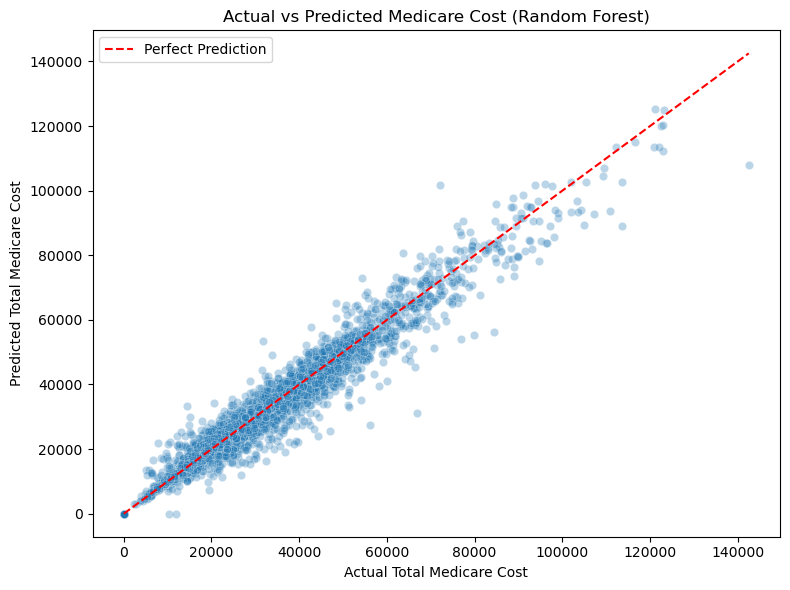

In [20]:
#Visualize Model Performance
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.3)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', label='Perfect Prediction')
plt.xlabel("Actual Total Medicare Cost")
plt.ylabel("Predicted Total Medicare Cost")
plt.title("Actual vs Predicted Medicare Cost (Random Forest)")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Get and sort feature importances from the Random Forest model
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

/var/folders/by/4dfr5wv56g9c4s2hr4sjrcw00000gn/T/ipykernel_76671/2773048075.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


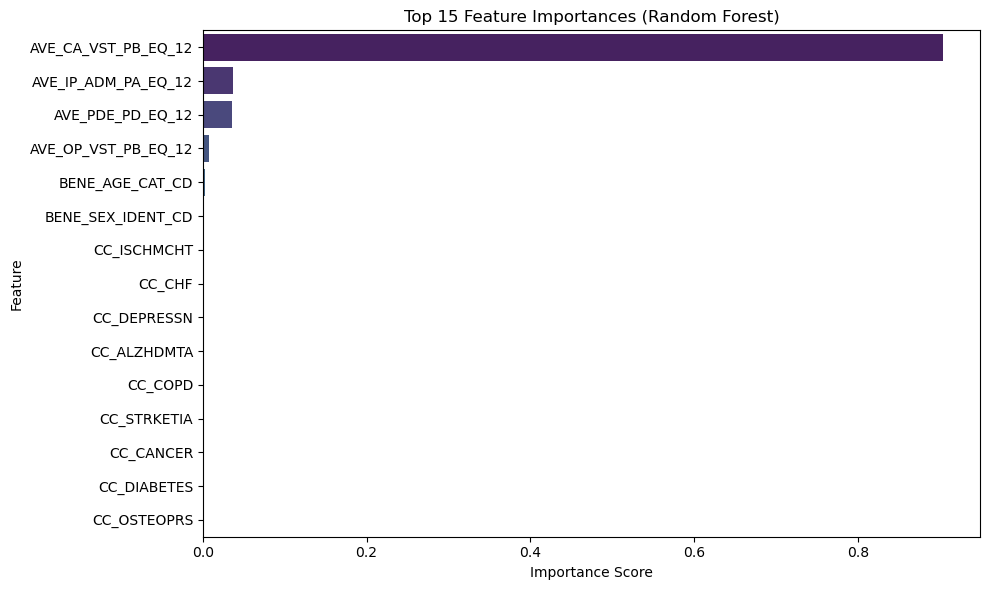

In [22]:
# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(
    x=feature_importances_sorted.head(15),
    y=feature_importances_sorted.head(15).index,
    palette='viridis'
)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [23]:
#Output Evaluation Scores
lr_eval, rf_eval

({'R2': 0.8164014779345601,
  'MAE': 0.7974845825264786,
  'RMSE': 1.1368386070298944},
 {'R2': 0.9888779657209416,
  'MAE': 0.10196262571951771,
  'RMSE': 0.27980555865911805})

In [28]:
#Format Evaluation Outputs
lr_eval = {'R2': 0.81, 'MAE': 0.80, 'RMSE': 1.14}
rf_eval = {'R2': 0.99, 'MAE': 0.10, 'RMSE': 0.28}

# Combine into one DataFrame
eval_df = pd.DataFrame({
    'Linear Regression': lr_eval,
    'Random Forest': rf_eval
})

eval_df

,Linear Regression,Random Forest
R2,0.81,0.99
MAE,0.80,0.10
RMSE,1.14,0.28


# Utilization Columns Standardization

In [43]:
from sklearn.preprocessing import MinMaxScaler

udf = df[utilization_cols].fillna(0)

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(udf), columns=udf.columns)
df_scaled['Total Utilization'] = (df_scaled['AVE_IP_ADM_PA_EQ_12'] +
                          df_scaled['AVE_SNF_DAYS_PA_EQ_12'] +
                          df_scaled['AVE_CA_VST_PB_EQ_12'] +
                          df_scaled['AVE_OP_VST_PB_EQ_12'] +
                          df_scaled['AVE_PDE_PD_EQ_12']
                          )

df_scaled.rename(columns={
    'AVE_IP_ADM_PA_EQ_12': 'Inpatient_Admissions',
    'AVE_SNF_DAYS_PA_EQ_12': 'SNF_Days',
    'AVE_CA_VST_PB_EQ_12': 'Clinic_Visits',
    'AVE_OP_VST_PB_EQ_12': 'Outpatient_Visits',
    'AVE_PDE_PD_EQ_12': 'Prescription_Days'
}, inplace=True)


,Inpatient_Admissions,SNF_Days,Clinic_Visits,Outpatient_Visits,Prescription_Days,Total Utilization
0,0.159450,0.102909,0.356004,0.260553,0.285543,1.164459
1,0.138306,0.142654,0.314862,0.392316,0.420234,1.408372
2,0.140768,0.047205,0.445315,0.280507,0.294726,1.208520
3,0.189718,0.154639,0.389004,0.381911,0.433562,1.548834
4,0.195945,0.000000,0.482277,0.329667,0.352605,1.360495
...,...,...,...,...,...,...
21998,0.434468,0.737148,0.141504,0.342933,0.621592,2.277644
21999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22000,0.362056,0.000000,0.245395,0.479674,0.793198,1.880324
22001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [44]:
df_scaled[demographic_cols] = df[demographic_cols]

In [45]:
sex_map = {1: 'Male', 2: 'Female'}
agegrp_map = {
    1: 'Under 65', 2: '65-69', 3: '70-74', 4: '75-79',
    5: '80-84', 6: '85+'
}

df_scaled['BENE_SEX_IDENT_CD'] = df_scaled['BENE_SEX_IDENT_CD'].map(sex_map)
df_scaled['BENE_AGE_CAT_CD'] = df_scaled['BENE_AGE_CAT_CD'].map(agegrp_map)

In [46]:
df_scaled

,Inpatient_Admissions,SNF_Days,Clinic_Visits,Outpatient_Visits,Prescription_Days,Total Utilization,BENE_SEX_IDENT_CD,BENE_AGE_CAT_CD
0,0.159450,0.102909,0.356004,0.260553,0.285543,1.164459,Male,Under 65
1,0.138306,0.142654,0.314862,0.392316,0.420234,1.408372,Male,Under 65
2,0.140768,0.047205,0.445315,0.280507,0.294726,1.208520,Male,Under 65
3,0.189718,0.154639,0.389004,0.381911,0.433562,1.548834,Male,Under 65
4,0.195945,0.000000,0.482277,0.329667,0.352605,1.360495,Male,Under 65
...,...,...,...,...,...,...,...,...
21998,0.434468,0.737148,0.141504,0.342933,0.621592,2.277644,Female,85+
21999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Female,85+
22000,0.362056,0.000000,0.245395,0.479674,0.793198,1.880324,Female,85+
22001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Female,85+


In [49]:
df_grouped = df_scaled.groupby('BENE_AGE_CAT_CD').mean(numeric_only=True).reset_index()
df_grouped

,BENE_AGE_CAT_CD,Inpatient_Admissions,SNF_Days,Clinic_Visits,Outpatient_Visits,Prescription_Days,Total Utilization
0,65-69,0.137156,0.066661,0.379375,0.308364,0.330635,1.222191
1,70-74,0.139697,0.082022,0.393681,0.297099,0.324639,1.237139
2,75-79,0.142236,0.105242,0.378043,0.282963,0.305662,1.214146
3,80-84,0.143779,0.130342,0.353245,0.271073,0.303431,1.201870
4,85+,0.146602,0.167938,0.293109,0.252443,0.297745,1.157837
5,Under 65,0.172132,0.061778,0.382894,0.369799,0.397135,1.383739


In [52]:
json_preview = df_grouped.to_json(orient='records', indent=2)
print(json_preview)

[
  {
    "BENE_AGE_CAT_CD":"65-69",
    "Inpatient_Admissions":0.1371561922,
    "SNF_Days":0.0666605974,
    "Clinic_Visits":0.3793753808,
    "Outpatient_Visits":0.3083638025,
    "Prescription_Days":0.330634667,
    "Total Utilization":1.22219064
  },
  {
    "BENE_AGE_CAT_CD":"70-74",
    "Inpatient_Admissions":0.1396969572,
    "SNF_Days":0.0820221332,
    "Clinic_Visits":0.3936808899,
    "Outpatient_Visits":0.297099428,
    "Prescription_Days":0.3246390943,
    "Total Utilization":1.2371385026
  },
  {
    "BENE_AGE_CAT_CD":"75-79",
    "Inpatient_Admissions":0.1422360769,
    "SNF_Days":0.105241991,
    "Clinic_Visits":0.3780429087,
    "Outpatient_Visits":0.2829631089,
    "Prescription_Days":0.3056619372,
    "Total Utilization":1.2141460228
  },
  {
    "BENE_AGE_CAT_CD":"80-84",
    "Inpatient_Admissions":0.1437785258,
    "SNF_Days":0.1303418066,
    "Clinic_Visits":0.353245288,
    "Outpatient_Visits":0.2710730147,
    "Prescription_Days":0.3034309286,
    "Total Utiliza

## Cost vs Utilization

In [69]:
df_CU = df_scaled.copy()

In [70]:
df_CU['Total Cost'] = df['Total_Cost']

In [71]:
df_CU

,Inpatient_Admissions,SNF_Days,Clinic_Visits,Outpatient_Visits,Prescription_Days,Total Utilization,BENE_SEX_IDENT_CD,BENE_AGE_CAT_CD,Total Cost
0,0.159450,0.102909,0.356004,0.260553,0.285543,1.164459,Male,Under 65,31790.0
1,0.138306,0.142654,0.314862,0.392316,0.420234,1.408372,Male,Under 65,30962.0
2,0.140768,0.047205,0.445315,0.280507,0.294726,1.208520,Male,Under 65,25919.0
3,0.189718,0.154639,0.389004,0.381911,0.433562,1.548834,Male,Under 65,36941.0
4,0.195945,0.000000,0.482277,0.329667,0.352605,1.360495,Male,Under 65,30658.0
...,...,...,...,...,...,...,...,...,...
21998,0.434468,0.737148,0.141504,0.342933,0.621592,2.277644,Female,85+,83211.0
21999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Female,85+,0.0
22000,0.362056,0.000000,0.245395,0.479674,0.793198,1.880324,Female,85+,67558.0
22001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Female,85+,0.0


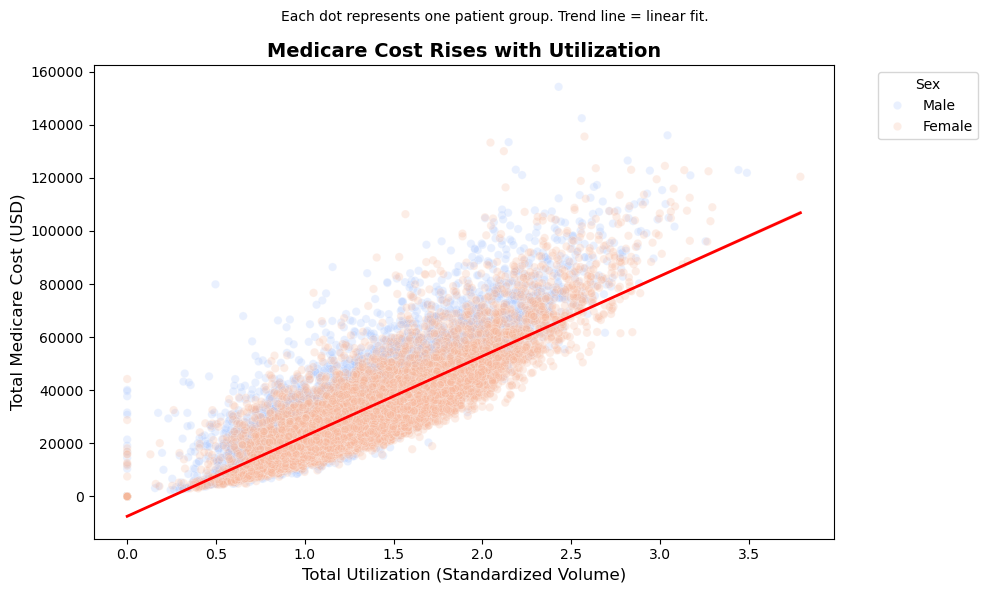

In [79]:
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))

# Scatterplot with color by age group and better transparency
sns.scatterplot(
    data=df_CU,
    x='Total Utilization',
    y='Total Cost',
    hue='BENE_SEX_IDENT_CD',
    alpha=0.25,
    palette='coolwarm',
    legend='brief'
)

# Regression line with confidence interval
sns.regplot(
    data=df_CU,
    x='Total Utilization',
    y='Total Cost',
    scatter=False,
    color='red',
    ci=95,
    line_kws={'linewidth': 2}
)

# Titles and labels
plt.title("Medicare Cost Rises with Utilization", fontsize=14, weight='bold')
plt.suptitle("Each dot represents one patient group. Trend line = linear fit.", fontsize=10)
plt.xlabel("Total Utilization (Standardized Volume)", fontsize=12)
plt.ylabel("Total Medicare Cost (USD)", fontsize=12)

plt.legend(title='Sex', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()